In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('ggplot')
from numpy_ext import rolling_apply
from scipy import stats
from arch import arch_model

In [3]:
def get_q2_data():
    df =pd.read_csv('./data/QRM-2022-cw1-data-b.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['DOG'].pct_change())
    df['loss'] = -100*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    return df.set_index('Date')

In [12]:
def es(loss: np.ndarray, var: np.ndarray):
    """
    Calculate expected shortfall.
    Takes array of length n+1, and calculates avg(loss) of first n items given loss[0:n]>var[-1]

    :param loss: array of n+1 observations
    :param var: array of n+1 observations, but we only care about the 'final' element 
    """
    # check if loss[0 to n inclusive] > var[n+1]
    loss = loss[:-1]
    breach_mask = loss>var[-1]
    if not breach_mask.sum():
        return 0
    return loss[breach_mask].sum() / breach_mask.sum()

def es_n(loss: np.ndarray, var: float):
    """
    Calculate expected shortfall.
    Takes array of length n, and calculates avg(loss) given loss[0:n]>var

    :param loss: array of n observations, previous loss 
    :param var: Value at Risk
    """
    # check if loss[0 to n inclusive] > var
    breach_mask = loss>var
    if not breach_mask.sum():
        # return = for no breaches
        return 0
    return loss[breach_mask].sum() / breach_mask.sum()

def print_viols_and_plot(df: pd.DataFrame, title: str):
    """
    Print summary of data including: 99 VaR violations, 95 VaR violations, and VaR/ES plot
    """
    data = df.copy()
    data.dropna(inplace=True)
    ax = data[['max_loss','var_95','var_99','es_95','es_99']].plot(style=['r','k--','b--','k-','b-'], lw=0.5)
    ax.set_ylabel("Daily portfolio loss (%) (positive part)")
    ax.set_xlabel("Time")
    
    months = mdates.MonthLocator((1,4,7,10))
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()

    num_days = (~data['var_95'].isna()).sum()
    viols_95 = (data['loss']>data['var_95']).sum()
    viols_99 = (data['loss']>data['var_99']).sum()

    print(f"Violations 95%: {viols_95}, {100*viols_95/num_days:.2f}%")
    print(f"Violations 99%: {viols_99}, {100*viols_99/num_days:.2f}%")

In [5]:
mean = 'constant'
rescale = False
def garch_var(x, alpha):
    
    model = arch_model(x.dropna(),
                    mean=mean, 
                    vol='GARCH', 
                    p=1, q=1, rescale=rescale, dist='normal')

    model_fit = model.fit(update_freq=-1, disp=0)
    forecasts = model_fit.forecast(reindex=False)
    var = forecasts.variance.iloc[0,0]
    q = np.quantile(model_fit.std_resid.values, alpha)
    std = np.sqrt(var)
    value_at_risk = q*std + model_fit.params.mu
    return value_at_risk

def garch_es(x, alpha):
        
    model = arch_model(x.dropna(),
                    mean=mean, 
                    vol='GARCH', 
                    p=1, q=1, rescale=rescale, dist='normal')

    model_fit = model.fit(update_freq=-1, disp=0)
    forecasts = model_fit.forecast(reindex=False)
    var = forecasts.variance.iloc[0,0]
    q = np.quantile(model_fit.std_resid, alpha)
    res_exp_sh = es_n(model_fit.std_resid, q)
    
    exp_sh = (var**0.5)*res_exp_sh
    return exp_sh

# Q2 a)

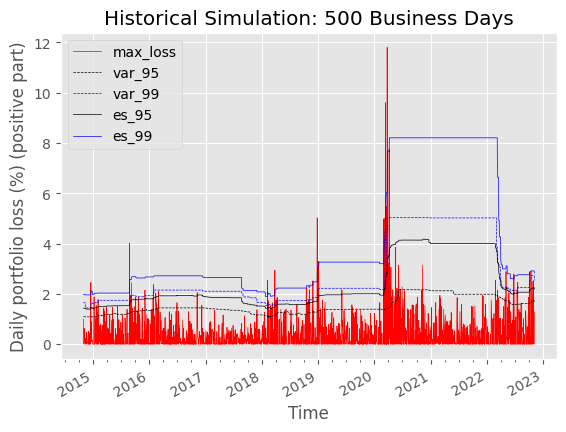

Violations 95%: 119, 5.90%
Violations 99%: 37, 1.83%


In [13]:
df = get_q2_data()

df['var_95'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.95)).shift(1)
df['var_99'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.99)).shift(1)

df['es_95'] = rolling_apply(es, 501, df['loss'].values, df['var_95'].values)
df['es_99'] = rolling_apply(es, 501, df['loss'].values, df['var_99'].values)
df_a = df.copy()

print_viols_and_plot(df_a, title='Historical Simulation: 500 Business Days')

# Q2 b)

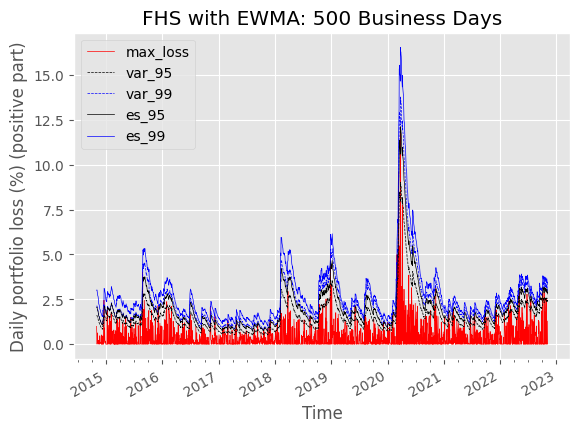

Violations 95%: 102, 5.05%
Violations 99%: 24, 1.19%


In [14]:
df = get_q2_data()

df['std_forc'] = 0

alpha = 0.06
for i in range(2, len(df)):
    df.iloc[i, 4] = np.sqrt(alpha*(df.iloc[i-1,2]**2) + (1-alpha)*(df.iloc[i-1,4]**2))


df['z_t'] = df['loss']/df['std_forc']
df.replace([np.inf, -np.inf], 0, inplace=True)

# shift 1 as quartile needs the n previous
df['q_95'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.95)).shift(1)
df['q_99'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.99)).shift(1)

df['es_95_z_t'] = rolling_apply(es, 501, df['z_t'].values, df['q_95'].values)
df['es_99_z_t'] = rolling_apply(es, 501, df['z_t'].values, df['q_99'].values)



df['var_95'] = df['q_95']*df['std_forc']
df['var_99'] = df['q_99']*df['std_forc']
df['es_95'] = df['std_forc']*df['es_95_z_t']
df['es_99'] = df['std_forc']*df['es_99_z_t']

df_b = df.copy()
print_viols_and_plot(df_b, title="FHS with EWMA: 500 Business Days")

# Q2 c)

In [8]:
df = get_q2_data()

df['var_95']= df['loss'].rolling(500).apply(garch_var, kwargs=dict(alpha=0.95)).shift(1)
df['es_95']= df['loss'].rolling(500).apply(garch_es, kwargs=dict(alpha=0.95)).shift(1)

df['var_99']= df['loss'].rolling(500).apply(garch_var, kwargs=dict(alpha=0.99)).shift(1)
df['es_99']= df['loss'].rolling(500).apply(garch_es, kwargs=dict(alpha=0.99)).shift(1)

df_c = df.copy()
# takes ~3m

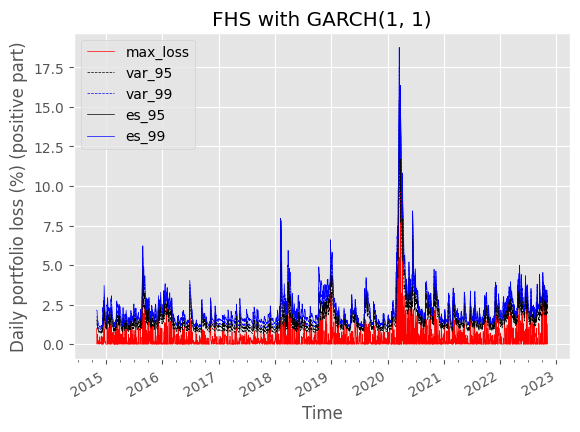

Violations 95%: 109, 5.40%
Violations 99%: 31, 1.54%


In [15]:
print_viols_and_plot(df_c, title = "FHS with GARCH(1, 1)")

# Backtesting

In [10]:
def log_lik(p: float, obs: pd.Series):
    """
    Likelihood ratio = -2*log(L_1/L_2)
    This function will calculate log(L_i) for any series of binomial obesrvations

    :param p: probability of success
    :param obs: Series of observations, values are 1 or 0
    """
    return obs.apply(lambda x: np.log(((1-p)**(1-x))*(p**x))).sum()

def lr_ind(alpha, exceeds: pd.Series):
    p_h0 = 1-alpha
    # fill value doesnt matter as we slice out. just need bool to retain dtype
    # look at obervations from t2 to tn
    obs_1x = exceeds[1:][exceeds.shift(1, fill_value=False)[1:]]
    obs_0x = exceeds[1:][~exceeds.shift(1, fill_value=False)[1:]]

    t_11 = obs_1x.sum()
    t_10 = len(obs_1x) - t_11

    t_01 = obs_0x.sum()
    t_00 = len(obs_0x) - t_01

    
    pi_11 = obs_1x.mean()
    pi_01 = obs_0x.mean()

    # print(pi_11, pi_01)
    ll_d = t_00*np.log(1-pi_01) + t_01*np.log(pi_01) + t_10*np.log(1-pi_11) 
    if pi_11:
        # account for pi_11 being 0
        ll_d+=  t_11*np.log(pi_11)
    ll_n = t_00*np.log(1-p_h0) + t_01*np.log(p_h0) + t_10*np.log(1-p_h0) + t_11*np.log(p_h0)

    return -2*(ll_n-ll_d)


def lr_uc(alpha: float, exceeds: pd.Series):
    """
    Calculate unconditional likelihood ratio statistic for any series of binomial obesrvations

    :param alpha: confidence level between 0 and 1
    :param exceeds: Series of booleans/ints, indicating if the event happened
    """
    # calc pi_hat MLE 
    obs = exceeds.astype(int)
    pi_hat = np.mean(obs)

    # return LR_UC for pi_hat and 1-alpha
    return -2*(log_lik(1-alpha, obs)-log_lik(pi_hat, obs))

def p_chi2(x: float, dof: int=1):
    """
    Calculate the p value for a chi2 distrubution

    :param x: test statistic value
    :param dof: Degrees of freedom for chi2 ist
    """
    return 1-stats.chi2.cdf(x, dof)

def str_ci(x):
    return str(x).split('.')[1]

def get_stats(data, title: str): 
    df=pd.DataFrame(columns=['Alpha', 'Violations (exp)', 'LR_uc', 'LR_uc - p','LR_joint', 'LR_joint - p', 'ES - p'])

    for alpha in [0.95, 0.99]:

        # str alpha for dataframe column lookup
        str_alpha = str_ci(alpha)

        # remove start data where there is no var
        non_na_data = data[~data[f'var_{str_alpha}'].isna()]

        num_days = len(non_na_data)
        viol_mask = (non_na_data['loss']>non_na_data[f'var_{str_alpha}'])
        num_viols = viol_mask.sum()


        # calculate p values for var
        expected_viols = (1-alpha)*num_days

        likelihood_uc = lr_uc(alpha, viol_mask)
        likelihood_ind = lr_ind (alpha, viol_mask)

        p_val_uc = p_chi2(likelihood_uc)
        p_val_joint = p_chi2(likelihood_uc+likelihood_ind)

        accept_str = lambda p_val, alpha : f"{'Accept' if p_val>(1-alpha) else 'Reject'}"

        accept_uc = accept_str(p_val_uc, alpha)
        accept_joint = accept_str(p_val_joint, alpha)

        # calculate p values for ES
        viols = non_na_data[viol_mask]
        xis = viols['loss']-viols[f'es_{str_alpha}']
        z = xis.sum()/np.sqrt((xis**2).sum())
        p_es = 1-stats.norm.cdf(z)

        # print(z, p_es)
        accept_es = accept_str(p_es, alpha)

    
        # print(f"\n{alpha=}. Violations (exp): {num_viols} ({expected_viols:.2f}).")
        # print(f"VaR LR_uc= {likelihood_uc:.3f}. p-val: {p_val_uc:.5f}. {accept_uc}")                
        # print(f"VaR LR_joint= {likelihood_uc+likelihood_ind:.3f}. p-val: {p_val_joint:.5f}. {accept_joint}")                
        # print(f"ES: Z={z:.2f}. p-val: {p_es:.5f}. {accept_es}")

        df.loc[len(df),:] = [alpha, f"{num_viols} ({expected_viols:.1f})", f"{likelihood_uc:.3f}",
            f"{p_val_uc:.5f}", f"{likelihood_uc+likelihood_ind:.3f}", f"{p_val_joint:.5f}",
            f"{p_es:.5f}" ]
    df.insert(0, 'Title', title)
    return df


In [11]:
backtesting_df = pd.concat(
        [get_stats(df_a, "Historical Simulation"),
        get_stats(df_b, "Historical Simulation (EWMA)"),
        get_stats(df_c, "FHS with Garch")]
        ).reset_index(drop=True)
backtesting_df

,Title,Alpha,Violations (exp),LR_uc,LR_uc - p,LR_joint,LR_joint - p,ES - p
0,Historical Simulation,0.95,119 (100.9),3.240,0.07187,11.228,0.00081,0.10098
1,Historical Simulation,0.99,37 (20.2),11.363,0.00075,30.923,0.00000,0.04133
2,Historical Simulation (EWMA),0.95,102 (100.9),0.013,0.91070,0.032,0.85855,0.42424
3,Historical Simulation (EWMA),0.99,24 (20.2),0.689,0.40662,2.503,0.11366,0.91511
4,FHS with Garch,0.95,109 (100.9),0.668,0.41382,3.242,0.07178,0.00632
5,FHS with Garch,0.99,31 (20.2),5.035,0.02484,11.049,0.00089,0.34402
